In [317]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [318]:
np.random.seed(0)
random.seed(0)

In [319]:
def distanceMatrix(nodes,N):
    dim = N + 1
    dis = np.zeros([dim,dim])
    for i in range(1,dim):
        for j in range(i+1,dim):
            a = np.array(nodes[i-1])
            b = np.array(nodes[j-1])
            c = np.sum((a-b)**2)
            c = np.sqrt(c)
#             c = np.abs(a-b)
#             c = np.sum(c)
            dis[i,j] = c
            dis[j,i] = c
    return dis

In [320]:
def load_TSP(path='datasets/eil51.txt'):
    with open(path, 'r') as f: 
        inputData = f.readlines()
    N = int(inputData[0].strip())
    nodes = []
    for line in inputData[1:]:
        line = line.strip()
        line = line.split(' ')
        nodes.append([int(line[1]),int(line[2])])
    dis = distanceMatrix(nodes,N)
    return N,nodes,dis

In [321]:
dataPath = ['eil51.txt','att48.txt','eil76.txt','pr76.txt']

In [322]:
data_info = []
maxDim = 0
for x in dataPath:
    N,nodes,dis = load_TSP('datasets/'+ x)
    if(N> maxDim):
        maxDim = N
    data_info.append([N,nodes,dis])

In [323]:
def decodeTSP(individual, n = maxDim):
    return np.array(np.argsort(individual[:n])+1)

In [324]:
def f_cost_TSP(individual,dis_TSP ,n = maxDim):
    cost = 0
    for i in range(n-1):
#         print(i,i+1)
        cost += dis_TSP[individual[i],individual[i+1]]
    cost += dis_TSP[individual[n-1],individual[0]]
    return cost

In [325]:
def Factorial_Cost(indiv,dims,dis_TSP):
    decode = decodeTSP(indiv,n=dims)
    return f_cost_TSP(decode,dis_TSP,n=dims)

In [326]:
def GeneratorIndiv(dims=maxDim):
#     indiv = np.random.random_sample((dims, ))
    indiv = np.random.permutation(range(1,dims+1))
    f_cost = []
    for i in range(len(data_info)):
        N,_,dis = data_info[i]
        cost = Factorial_Cost(indiv,N,dis)
        f_cost.append(cost)
    return indiv, f_cost

In [327]:
def Generate_Eval(sizePop, d = maxDim):
    population = []
    pop_cost = []
    for i in range(sizePop):
        pi, f_cost = GeneratorIndiv(d)
        population.append(pi)
        pop_cost.append(f_cost)
    population,pop_cost = np.asarray(population),np.asarray(pop_cost)
    rank = np.argsort(pop_cost,axis = 0) + 1
#     skill_factor = np.argmin(rank,axis = 1)+1
#     fitness = 1/np.min(rank,axis = 1) 
#     return population,pop_cost,rank,skill_factor,fitness
    return population,pop_cost,rank

In [328]:
def heSo(n,m,TH=0.4):
    # a1 + b1 = 1
    # a1*m+b1 = TH
    # a2*m + b2= TH
    # a2*n + b2 = 0
    a1 = (1-TH)/(1-m)
    b1 = 1 - a1
    a2 = TH/(m-n)
    b2 = (TH-a2*m)
    return a1,b1,a2,b2

In [329]:
def fm(a1,b1,a2,b2,n,m,r,TH=0.4):
    if r >=1 and r <m:
        return a1*r+b1
    elif r ==m:
        return TH
    elif r >= m+1:
        return a2*r+b2

In [330]:
def abilitiVector(rank,TH,n,m):
    a1,b1,a2,b2 = heSo(n,m,TH)
    abiVector =[]
    for x in range(len(rank)):
        df =[]
        for item in rank[x]:
            df.append(fm(a1,b1,a2,b2,n,m,item,TH))
        abiVector.append(df)
    return np.array(abiVector)

In [331]:
import math

def cross_SBX(p1, p2, nc = 2):
    u = np.random.random_sample()
    if u < 0.5:
        beta = math.pow(2*u, 1/(nc+1))
    else:
        beta = math.pow(0.5/(1-u), 1/(nc+1))

    c1 = 0.5*((1+beta)*p1 + (1-beta)*p2)
    c2 = 0.5*((1-beta)*p1 + (1+beta)*p2)

    return c1, c2

In [332]:
def Diff_Mutation(y1,y2,y3,y4):
    F = np.random.random_sample()
    return y1 + F * (y4 - y1 + y2 - y3)

In [333]:
def Poly_Mutation(p,nm = 20):
    u = np.random.random_sample()
    if u <= 0.5:
        phi = np.power(2*u,1/(nm+1)) -1
        return p + phi*p
    else:
        phi = 1 - np.power(2-2*u,1/(nm+1))
        return p + phi*(1-p)

In [334]:
def mutation(individual, e = 0.15):
    n = len(individual)
    res = np.array(individual)

    index1 = np.random.randint(n)
    index2 = np.random.randint(n)
    while index1 == index2:
        index2 = np.random.randint(n)

    res[index1] -= e
    res[index2] += e

    return res

In [335]:
def cross_pmx(p1, p2):
    n = p1.shape[0]
    # min = int(n/4)
    # max = int(n - n/4)

    if n > 13:
        cross = 10
    else:
        cross = 0
    #if(np.random.random_sample() < 0.01): cross = 25
    
    index1 = np.random.randint(1, n-cross)
    index2 = index1 + cross
    #while index1 == index2:
    #    index2 = np.random.randint(1, n-1)
   
    # if index1 > index2:
    #     temp = index1
    #     index1 = index2
    #     index2 = temp

    #print(index1, index2)

    o1 = np.array(p2)
    o2 = np.array(p1)

    pos1 = np.full(n+1, -1, dtype=int)
    pos2 = np.full(n+1, -1, dtype=int)
    for i in range(index1, index2+1):
        pos1[o1[i]] = i
        pos2[o2[i]] = i
        
    for i in range(n):
        if index1 <= i and i <= index2: continue

        id1 = i
        while True:
            if pos1[p1[id1]] == -1:
                o1[i] = p1[id1]
                break
            id1 = pos1[p1[id1]]
        
        id2 = i
        while True:
            if pos2[p2[id2]] == -1:
                o2[i] = p2[id2]
                break
            id2 = pos2[p2[id2]]
    
    return o1, o2
def mutation_swap(individual):
    n = len(individual)
    res = np.array(individual)

    index1 = np.random.randint(n)
    index2 = np.random.randint(n)
    while index1 == index2:
        index2 = np.random.randint(n)

    temp = res[index1]
    res[index1] = res[index2]
    res[index2] = temp

    return res

In [336]:
def Offspring_Generation(pop,abiVector,task,Pa,Pb,m):
    n = pop.shape[0]
    x_star = pop[abiVector[:,task].argmax()]
    offs_gen = []
    abi_gen = []
    for indiv in range(int(m/2)):
        index1 = np.random.randint(n)
        while True:
            index2 = np.random.randint(n)
            if index1 != index2: break
        p1,p2 = pop[index1],pop[index2]
        if np.random.random_sample() < Pa:
            c1,c2 = cross_pmx(p1,p2)
#             if np.random.random_sample() < Pb:
#                 c1 = Diff_Mutation(c1,p1,p2,x_star)
#                 c2 = Diff_Mutation(c2,p2,p1,x_star)
        else:
            c1 = mutation_swap(p1)
            c2 = mutation_swap(p2)
#             c1 = mutation(p1, e = 0.15)
#             c2 = mutation(p2, e = 0.15)
        if np.random.random_sample() <= 0.5:
            a1 = abiVector[index1]
            a2 = abiVector[index2]
        else:
            a1 = abiVector[index2]
            a2 = abiVector[index1]
        
        offs_gen.append(c1)
        offs_gen.append(c2)
        abi_gen.append(a1)
        abi_gen.append(a2)
    return np.array(offs_gen), np.array(abi_gen) 

In [337]:
MAX = np.iinfo(np.int64).max

In [338]:
def Select_Eval(offs_gen,abi_gen,task,k):
    size_gen = offs_gen.shape[0]
    tmp = np.arange(size_gen)
    random.shuffle(tmp)
    
    new_gen = []
    new_fc = []
    for x in tmp:
        indiv = offs_gen[x]
        abi_x = abi_gen[x]
        fc = []
        for js in range(k):
            if js == task or np.random.random_sample() <= abi_x[js]:
                N,_,dis = data_info[js]
                cost = Factorial_Cost(indiv,N,dis)
            else:
                cost = MAX
            fc.append(cost)
        new_fc.append(fc)
        new_gen.append(indiv)
    return np.array(new_gen),np.array(new_fc)

In [339]:
def updateAbility(pop_cost,TH,n,m):
    rank = np.argsort(-pop_cost,axis = 0) + 1
    abiVector = abilitiVector(rank,TH,n,m)
    return abiVector

In [340]:
from tqdm import tqdm

In [341]:
def SREMTO(n,TH,Pa,Pb,epochs=20000):
    population,pop_cost,rank = Generate_Eval(n)
    k = len(data_info)
    m = int(n/k)
    abiVector = abilitiVector(rank,TH,n,m)
    
    log = []
    for epoch in tqdm(range(epochs)):
        off_gen = []
        off_fc = []
        for task in range(k):
            index = abiVector[:,task].argsort()[-m:]
            group = [population[index],pop_cost[index],rank[index],abiVector[index]]
            
            offs_gen,abi_gen = Offspring_Generation(group[0],group[3],task,Pa,Pb,m)
            
            new_gen,new_fc = Select_Eval(offs_gen,abi_gen,task,k)
            
            off_gen.append(new_gen)
            off_fc.append(new_fc)
        
        
        off_gen = np.concatenate(off_gen)
        off_fc = np.concatenate(off_fc)
        
        population = np.concatenate([population,off_gen],axis=0)
        pop_cost = np.concatenate([pop_cost,off_fc],axis=0)
        
        #update
        tmp_pop = []
        tmp_cost = []
        for task in range(k):
            index = pop_cost[:,task].argsort()[:m]
            tmp_pop.append(population[index])
            tmp_cost.append(pop_cost[index])
        population = np.concatenate(tmp_pop)
        pop_cost = np.concatenate(tmp_cost)
        abiVector = updateAbility(pop_cost,TH,n,m)
        
        best = []
        for task in range(k):
            index = pop_cost[:,task].argmin()
            indiv = population[index]
            N,_,dis = data_info[task]
            cost = Factorial_Cost(indiv,N,dis)
            best.append(cost)
        log.append(best)
    return np.array(log)

In [342]:
log = SREMTO(1000,0.5,0.7,0.1)

100%|██████████| 20000/20000 [41:33<00:00,  8.02it/s] 


In [343]:
k = 4

In [344]:
def show(log):
    plt.figure(figsize=(20, 15))
    for i in range(k):
        name = dataPath[i].split('.')[0]
        plt.subplot(2,2,i+1)
        best = log[:,i].min()
        plt.plot(log[:,i])
        plt.title('TSP {i} best: {best}'.format(i=name.upper(),best=best))
    plt.show()

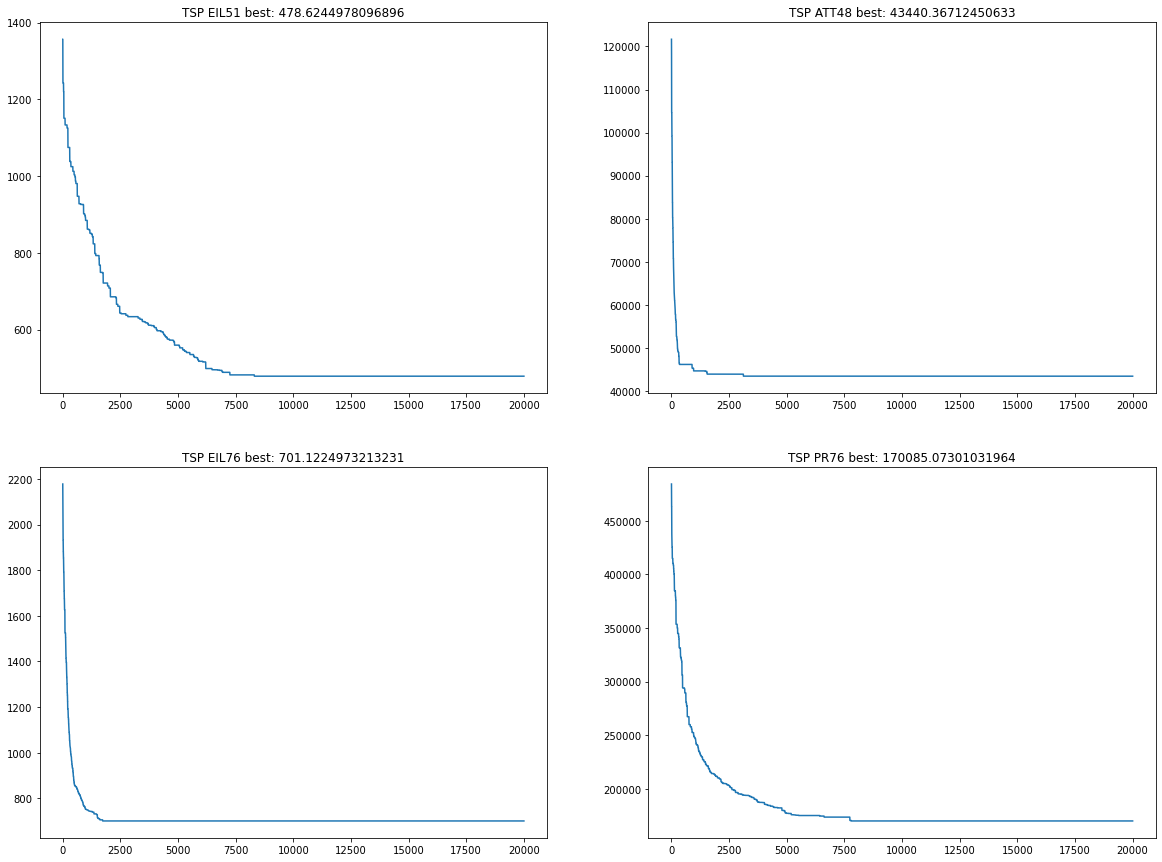

In [345]:
show(log)